<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [6.3  Predictive Control](https://jckantor.github.io/cbe30338-2021/06.03-Predictive-Control.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.0 Projects](https://jckantor.github.io/cbe30338-2021/07.00-Projects.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/06.04-Predictive-Control-2.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/06.04-Predictive-Control-2.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 6.4  Predictive Control


### 6.4.1 Model

We will use the two-state model for a single heater/sensor assembly for the calculations that follow.

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1 u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

The model is recast into linear state space form as

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where

$$x = \begin{bmatrix} T_{H,1} \\ T_{S,1} \end{bmatrix}
\qquad
u = \begin{bmatrix} u_1 \end{bmatrix}
\qquad
d = \begin{bmatrix} T_{amb} \end{bmatrix}
\qquad
y = \begin{bmatrix} T_{S,1} \end{bmatrix}$$

and

$$A = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} \end{bmatrix}
\qquad
B_u = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}
\qquad
B_d = \begin{bmatrix} \frac{U_a}{C_p^H} \\ 0 \end{bmatrix}
\qquad
C = \begin{bmatrix} 0 & 1 \end{bmatrix}$$


## 6.4.1 Feedforward Optimal Control

An optimal control policy minimizes the differences

\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_H^{SP}(t) - T_H(t)\|^2\,dt \\
\end{align*}

subject to constraints

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior knowledge of $d(t)$.

## 6.4.2 Adapting for use in a Feedback Loop

The problem with feedforward control is that it makes no use of measurements and information that become availiable in the course of normal operation. The necessary adaptations are:

1. Assume knowledge of the state is available to establish initial conditions for the optimal control calculation. We'll use an observer to make this possible.

2. We need to assume something about future values of the setpoint. We will assume the current SP value will be constant into the future.

3. We need to know future values of the disturbance. We will assume the disturbance is constant and that we have a current estimate.



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor

# state space model
A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
Bu = np.array([[alpha*P1/CpH], [0]])     # single column
Bd = np.array([[Ua/CpH], [0]])           # single column
C = np.array([[0, 1]])                   # single row

Tamb = 20

## 6.4.3 TCLab Event Loop

Borrowing from notebook 4.6.

In [3]:
# Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

In [4]:
def tclab_observer(L, t_now=0, x_hat=[Tamb, Tamb], d_hat=[Tamb]):
    
    while True:
        # yield current state, get MV for next period
        t_next, Q, T_measured = yield x_hat
        
        # model prediction
        x_predict = x_hat + (t_next - t_now)*(A@x_hat + Bu@[Q] + Bd@d_hat)
        
        # measurement correction
        y = np.array([T_measured])
        x_hat = x_predict - (t_next - t_now)*np.dot(L, np.dot(C, x_predict) - y)
        t_now = t_next

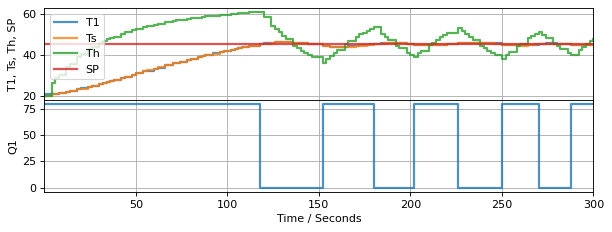

TCLab Model disconnected successfully.


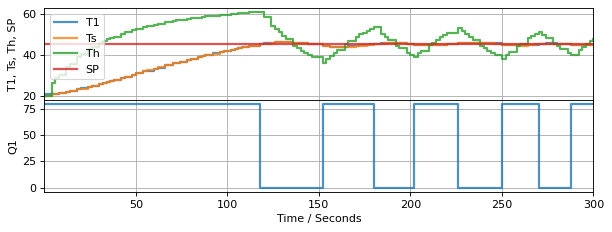

In [5]:
from tclab import setup, clock, Historian, Plotter

Tamb = 21
SP = 45

t_final = 300
t_step = 2

# create a controller instance
controller = relay(0, 80)
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: lab.T1), 
                   ('Q1', lab.Q1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP'], ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1])
        U1 = controller.send([SP, Ts])
        lab.Q1(U1)
        p.update(t)

## 6.4.4 What do we need for Predictive Control?

In [11]:
Tamb = 21
SP = 45

t_horizon = 500
dt = 2
n = round(t_horizon/dt)
t_grid = np.linspace(0, t_horizon, n+1)

# add $u$ as a decision variable
u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
x = {t: cp.Variable(2) for t in t_grid}
y = {t: cp.Variable(1) for t in t_grid}

# least-squares optimization objective
objective = cp.Minimize(sum((y[t]-r(t))**2 for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
inputs = [u[t] <= 100 for t in t_grid]
IC = [x[0] == np.array([30, Tamb])]

problem = cp.Problem(objective,  model + IC + output + inputs)
problem.solve()

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S")
ax[0].plot(t_grid, [r(t) for t in t_grid], label="SP")
ax[0].set_ylabel("deg C")
ax[0].legend()
ax[1].plot(t_grid, [u[t].value for t in t_grid], label="u(t)")
ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

NameError: name 'r' is not defined

In [110]:

def predictive_control(t_horizon=600, dt=2):
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(2) for t in t_grid}
    y = {t: cp.Variable(1) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]
    model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
    MV = 0
    
    while True:
        print(MV)
        SP, Th, Ts = yield MV
        objective = cp.Minimize(sum((y[t]-SP)**2 for t in t_grid))
        IC = [x[0] == np.array([Th, Ts])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve()
        MV = u[0].value[0]

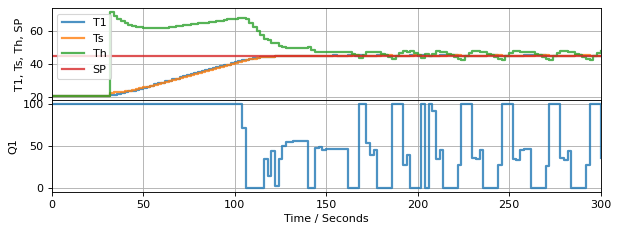

TCLab Model disconnected successfully.


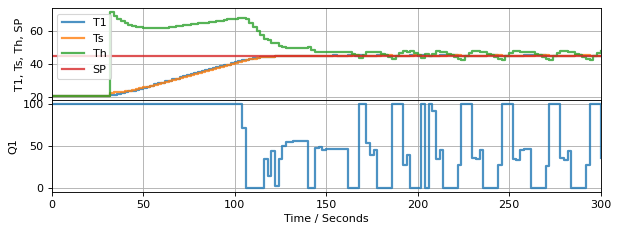

In [111]:
t_final = 300
t_step = 2

# create a controller instance
controller = predictive_control()
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: lab.T1), 
                   ('Q1', lab.Q1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP'], ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1])
        U1 = controller.send([SP, Th, Ts])
        lab.Q1(U1)
        p.update(t)

<!--NAVIGATION-->
< [6.3  Predictive Control](https://jckantor.github.io/cbe30338-2021/06.03-Predictive-Control.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.0 Projects](https://jckantor.github.io/cbe30338-2021/07.00-Projects.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/06.04-Predictive-Control-2.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/06.04-Predictive-Control-2.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>